In [1]:
# Import necessary modules
import torch
import torch.nn as nn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2)) ## Two dimensional random numbers, total 200
y = np.ones(len(x)) #len(y)=200

In [3]:
y[x[:,0] * x[:,1]<0] = 0 ## y = 0 or 1 depending on where x coordinates

In [4]:
## Split data into train and validation sets
n_train = 100

x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)

x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))

<Figure size 600x600 with 0 Axes>

Text(0, 0.5, '$x_2$')

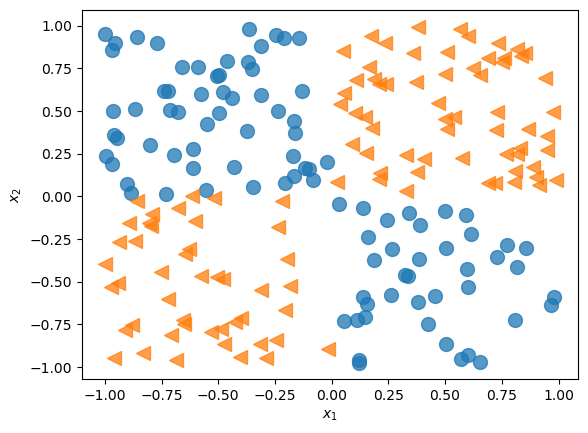

In [5]:
# y ==0 Boolean operator, take on the indices 
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [6]:
## use DataLoader for traning
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Create user defined layer from pytorch

In [7]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size,
                noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [14]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)  ## Above class is used here.
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >=0.5).float()

In [20]:
torch.manual_seed(1)
num_epochs = 300
model = MyNoisyModule()

In [21]:
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [22]:
## Define several functions for traning and record of traning
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
torch.manual_seed(1)
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

In [23]:
## Train the model on the traning data set and test it on validation data set

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0] ## Prediction
        loss = loss_fn(pred, y_batch)     ## Calculate loss funtion
        loss.backward()   ## backpropagation
        optimizer.step()  ## Updating parameters
        optimizer.zero_grad() ## Clear the gradients of all optimized tensors
        loss_hist_train[epoch] += loss.item() ## record the loss value
        is_correct = (  ## calculate the number of correct prediction.
            (pred >=0.5).float() == y_batch
        ).float()
        accuracy_hist_train[epoch] += is_correct.mean() ## record the correct prediction
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    # Prediction on validation data set using the same parameters used in the traning.
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

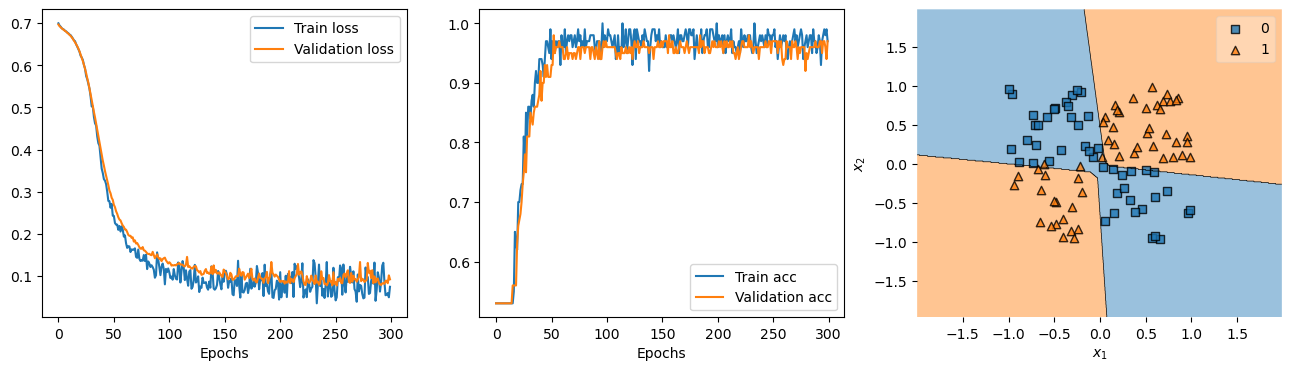

In [24]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train)
plt.plot(loss_hist_valid)
plt.legend(['Train loss', 'Validation loss'])
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train)
plt.plot(accuracy_hist_valid)
plt.legend(['Train acc', 'Validation acc'])
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X = x_valid.numpy(),
                      y = y_valid.numpy().astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$')
#ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$')
#ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### What was the role of random noise?